In [1]:
%pylab inline
import pandas as pd
import numpy as np
import pickle

import tensorflow as tf

from sklearn.metrics import roc_curve, auc

from keras.models import Model
from keras import losses
from keras import backend as K
from keras.layers import Dense, Embedding, Input
from keras.preprocessing import text, sequence
from keras.layers import LSTM, GRU, Bidirectional, GlobalMaxPool1D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [ ]:
with open('trainHistoryDict_Orig', 'rb') as f:
     history = pickle.load(f)

In [ ]:
print(history['val_loss'])

In [2]:
def preprocess_1(ftrain, ftest, max_features=20000, maxlen=100):
    train = pd.read_csv(ftrain)
    test  = pd.read_csv(ftest)

    list_sentences_train = train["comment_text"].fillna(" ").values
    list_sentences_test = test["comment_text"].fillna(" ").values
    list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

    train_sentence_filtered = train[   (train.toxic == 1)   | (train.severe_toxic == 1) \
                                 | (train.obscene == 1) | (train.threat == 1)   \
                                 | (train.insult ==  1) | (train.identity_hate == 1) ]
    list_filtered_train = train_sentence_filtered["comment_text"].fillna(" ").values

    tokenizer = text.Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(list_filtered_train))
    list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
    list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

    X_train = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
    X_test = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)
    y = train[list_classes].values
    return X_train, X_test, y

def preprocess_2(ftrain, ftest, max_features=20000, maxlen=100):
    train_orig = pd.read_csv(ftrain)
    test_orig  = pd.read_csv(ftest)

    train_effective_samples = train_orig[   (train_orig.toxic == 1)   | (train_orig.severe_toxic == 1) \
                                        | (train_orig.obscene == 1) | (train_orig.threat == 1)   \
                                      | (train_orig.insult ==  1) | (train_orig.identity_hate == 1) ]
    # repeat the threat data at the beginning
    threat_samples = train_orig[train_orig.threat == 1]
    word_fit       = threat_samples.append(train_effective_samples)
    train_combined = threat_samples.append(train_orig)
    
    list_sentences_fit = word_fit["comment_text"].fillna(" ").values
    list_sentences_train = train_combined["comment_text"].fillna(" ").values
    list_sentences_test = test_orig["comment_text"].fillna(" ").values
    list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    
    tokenizer = text.Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(list_sentences_fit))
    list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
    list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

    X_train = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
    X_test = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)
    y = train_combined[list_classes].values
    return X_train, X_test, y    
    

In [3]:
train_file = "./input/train.csv"
test_file  = "./input/test.csv"
max_features = 20000
maxlen = 100

X_train, X_test, y = preprocess_2(train_file, test_file, max_features, maxlen)

In [ ]:
print(X_train.shape, y.shape, X_test.shape)

In [ ]:
print('# of toxic text: ', train[train.toxic == 1].fillna(" ").values.shape)
print('# of severe_toxic text: ',train[train.severe_toxic == 1].fillna(" ").values.shape)
print('# of obscene text: ',train[train.obscene == 1].fillna(" ").values.shape)
print('# of threat text: ',train[train.threat == 1].fillna(" ").values.shape)
print('# of insult text: ',train[train.insult ==  1].fillna(" ").values.shape)
print('# of identity_hate text: ',train[train.identity_hate == 1].fillna(" ").values.shape)

In [4]:
maxlen = 100
max_features = 20000

# define the Keras model graph
def get_model():
    embed_size = 600
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(GRU(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.3)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [5]:
model = get_model()
file_path="weights_GRU_021718.best.hdf5"
model.load_weights(file_path)
y_pred_sample = model.predict(X_train[-15000:-1])
y_pred = K.variable(y_pred_sample)
y_true = K.variable(y[-15000:-1])

In [ ]:
score = K.eval(losses.binary_crossentropy(y_true, y_pred))
values, indices = tf.nn.top_k(score, k=30, sorted=True)

In [ ]:
print(K.eval(values))
print(K.eval(indices))

for idx in K.eval(indices):
    print(K.eval(y_true[idx]), K.eval(y_pred[idx]))

In [6]:
# ROC(AUC) analysis

y_score_arr = K.eval(y_pred)
y_true_arr = K.eval(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_true_arr[:,i], y_score_arr[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

avg_auc = sum(list(roc_auc.values())) / 6.0
# Compute micro-average ROC curve and ROC area
print("Average AUC: %.5f" % avg_auc)

Average AUC: 0.98667


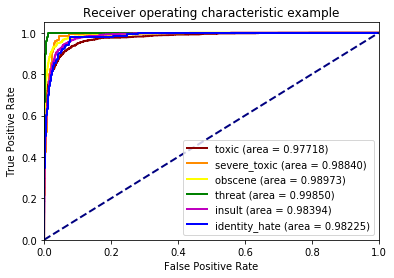

In [7]:
fig = plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkred',
         lw=lw, label='toxic (area = %0.5f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='severe_toxic (area = %0.5f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='yellow',
         lw=lw, label='obscene (area = %0.5f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3], color='green',
         lw=lw, label='threat (area = %0.5f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4], color='m',
         lw=lw, label='insult (area = %0.5f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5], color='b',
         lw=lw, label='identity_hate (area = %0.5f)' % roc_auc[5])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [8]:
fig.savefig('cmp_GRU.png', dpi=300)